In [45]:
import torch 
from torch.utils.data import DataLoader 
from tqdm import tqdm 
import numpy as np
from typing import List, Optional, Tuple
import sys 
sys.path.insert(0, "../")
from DEFAULTS import BASE_PATH 
from loaders import get_dataset 
from model_builder import get_pretrained_model_v2 

DATASET = "neural-activity-states"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
GLOBAL_POOL = "avg"


def get_classes(dataset: str):
    if dataset == "optim":
        return ["Actin", "Tubulin", "CaMKII", "PSD95"]  
    elif dataset == "neural-activity-states":
        return ["Block", "0Mg", "GluGly", "48hTTX"]
    elif dataset == "peroxisome":
        return ["6hGluc", "6hMeOH"]
    elif dataset == "polymer-rings":
        return ["CdvB1", "CdvB2"]
    elif dataset == "dl-sim":
        return ["adhesion", "factin", "microtubule", "mitosis"]
    else:
        raise ValueError(f"Dataset {dataset} not supported")
    
CLASSES = get_classes(DATASET)
N_CLASSES = len(CLASSES)


### Load Model

In [46]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Running on {DEVICE} ---")

model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None,
    mask_ratio=0.0,
    pretrained=True if "imagenet" in WEIGHTS.lower() else False,
    in_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)
model.to(DEVICE)
model.eval()

--- Running on cuda ---
mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


### Load dataset

In [47]:
_, _, test_loader = get_dataset(
    name=DATASET,
    transform=None,
    training=True,
    path=None,
    batch_size=cfg.batch_size,
    n_channels=3 if "imagenet" in WEIGHTS.lower() else 1,
)


=== NAS dataset ===
(array([0., 1., 2., 3.], dtype=float32), array([578, 578, 578, 578]))
(array([0., 1., 2., 3.], dtype=float32), array([77, 77, 77, 77]))
(array([0., 1., 2., 3.], dtype=float32), array([114, 114, 114, 114]))
Training size: 2312
Validation size: 308
Test size: 456




### Embed dataset using model

In [48]:
embeddings, labels, dataset_idx = [], [], []
with torch.no_grad():
    for img, metadata in tqdm(test_loader):
        img = img.to(DEVICE)
        label = metadata["label"]
        d_id = metadata["dataset-idx"]
        output = model.forward_features(img)
        embeddings.extend(output.data.cpu().numpy())
        labels.extend(label)
        dataset_idx.extend(d_id)

embeddings = np.array(embeddings)
labels = np.array(labels)
dataset_idx = np.array(dataset_idx)
print(embeddings.shape, labels.shape)
assert embeddings.shape[0] == labels.shape[0]

100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

(456, 384) (456,)


(456, 384)


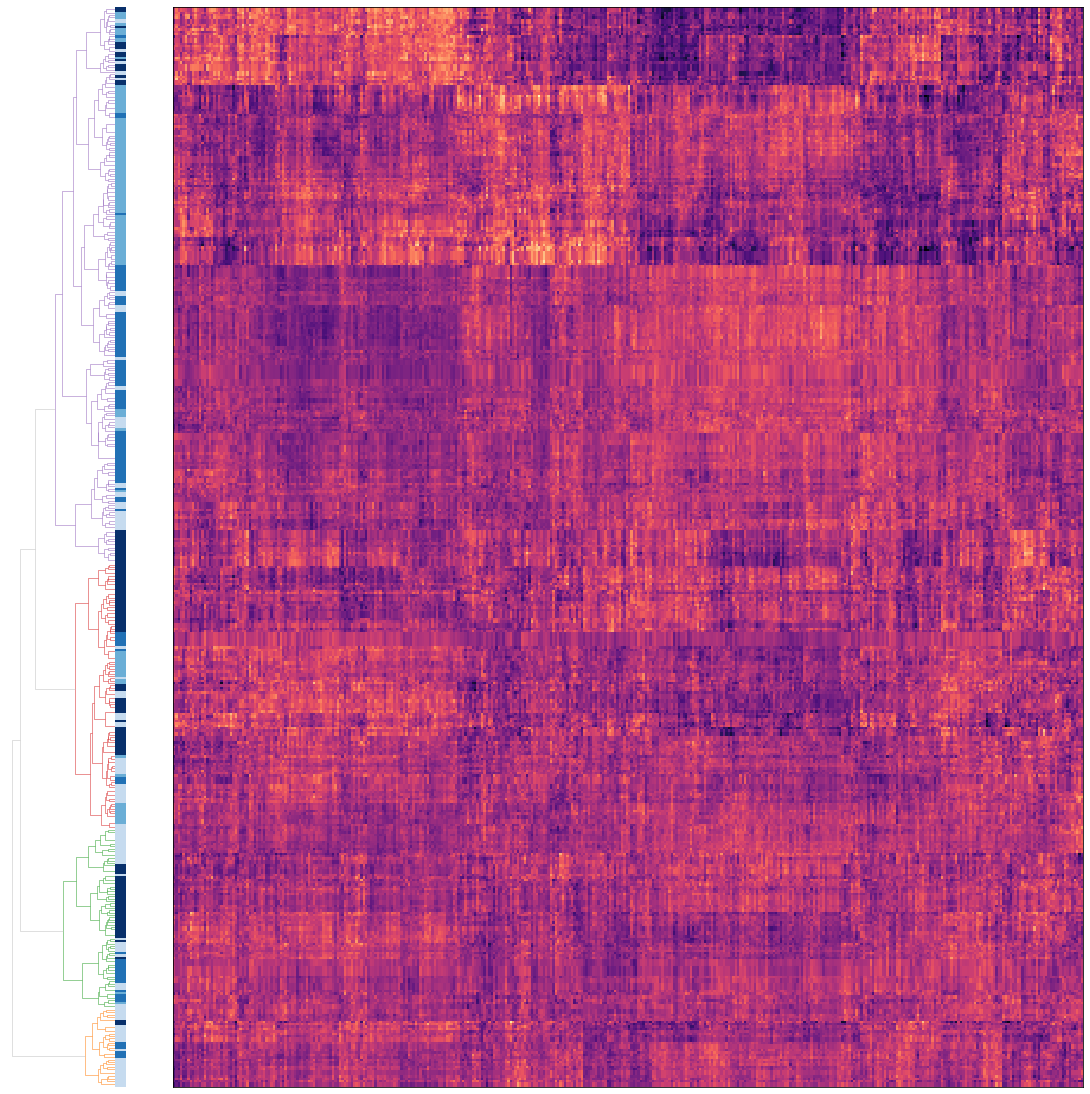

In [49]:
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib

if labels.dtype == np.float32:
    labels = labels.astype(np.int32)
uniques = np.unique(labels)
D = embeddings 
print(D.shape)
D = StandardScaler().fit_transform(D) 
Y1 = hierarchy.linkage(D, method="ward", metric="euclidean")
clusters1 = hierarchy.fcluster(Y1, N_CLASSES, criterion="maxclust")

# Find the distance threshold that gives the same clustering
distances = Y1[:, 2]  # The third column of the linkage matrix contains the distances
threshold = sorted(distances)[1-N_CLASSES]  # n_samples - n_clusters = -3 for 4 clusters d
Y2 = hierarchy.linkage(D.T, method="ward", metric="euclidean")

fig = plt.figure(figsize=(15, 15))
ax3 = fig.add_axes([0, 0, 0.1, 1.0])
ax3.set_xticks([])
ax3.set_yticks([])
fig.gca().invert_yaxis() 
ax3.axis("off")

zmap = plt.get_cmap("tab10", len(uniques))

Z1 = hierarchy.dendrogram(
    Y1, orientation="left",
    above_threshold_color="silver",
    ax=ax3,
    color_threshold=threshold
)
Z2 = hierarchy.dendrogram(
    Y2, orientation="right",
    above_threshold_color="silver",
    no_plot=True
)
for collection in ax3.collections:
    collection.set_linewidth(0.5)

ax4 = fig.add_axes([0.1,0,0.01,1.0])
ax4.set_xticks([])
ax4.set_yticks([])
ax4.axis('off')

cmap = plt.get_cmap("Blues", len(set(uniques)) + 1)
all_colors = []
for i, leaf in enumerate(Z1["leaves"]):
    all_colors.append(cmap(labels[leaf] + 1))
    ax4.barh(i + 0.5, 1, 1.0, color=cmap(labels[leaf] + 1))
#     # ax4.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
ax4.set(
    ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
)
ax4.invert_yaxis()
    

axmatrix2 = fig.add_axes([0.15,0,0.85, 1.0])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

sorted_co_matrix = D[idx1,:]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="magma")
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis





### Quantitative Analysis of clustering tendency

1 [7, 10, 1, 15]
2 [0, 73, 3, 0]
3 [28, 5, 79, 0]
4 [79, 26, 31, 99]


<ipython-input-50-43c8595c5416>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(CLASSES, rotation=25)


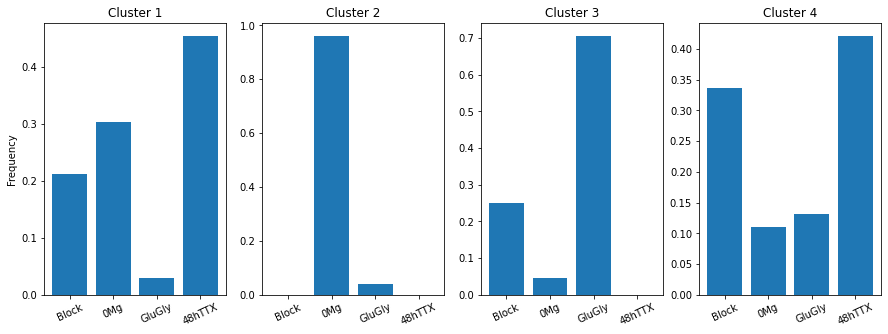

In [50]:
frequencies = {
    key: [0] * len(np.unique(labels)) for key in np.unique(clusters1)
}

uniques, counts = np.unique(labels, return_counts=True)
num_clusters = len(np.unique(clusters1))

for cluster_id, true_label in zip(clusters1, labels):
    frequencies[cluster_id][true_label] += 1

for key, value in frequencies.items():
    print(key, value)

fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    total = sum(frequencies[i+1])
    axs[i].bar(CLASSES, [item / total for item in frequencies[i+1]])
    axs[i].set_title(f"Cluster {i+1}")
    axs[i].set_xticklabels(CLASSES, rotation=25)
    axs[0].set_ylabel("Frequency")
plt.show()



### Exploratory code

[1 2 3 4]


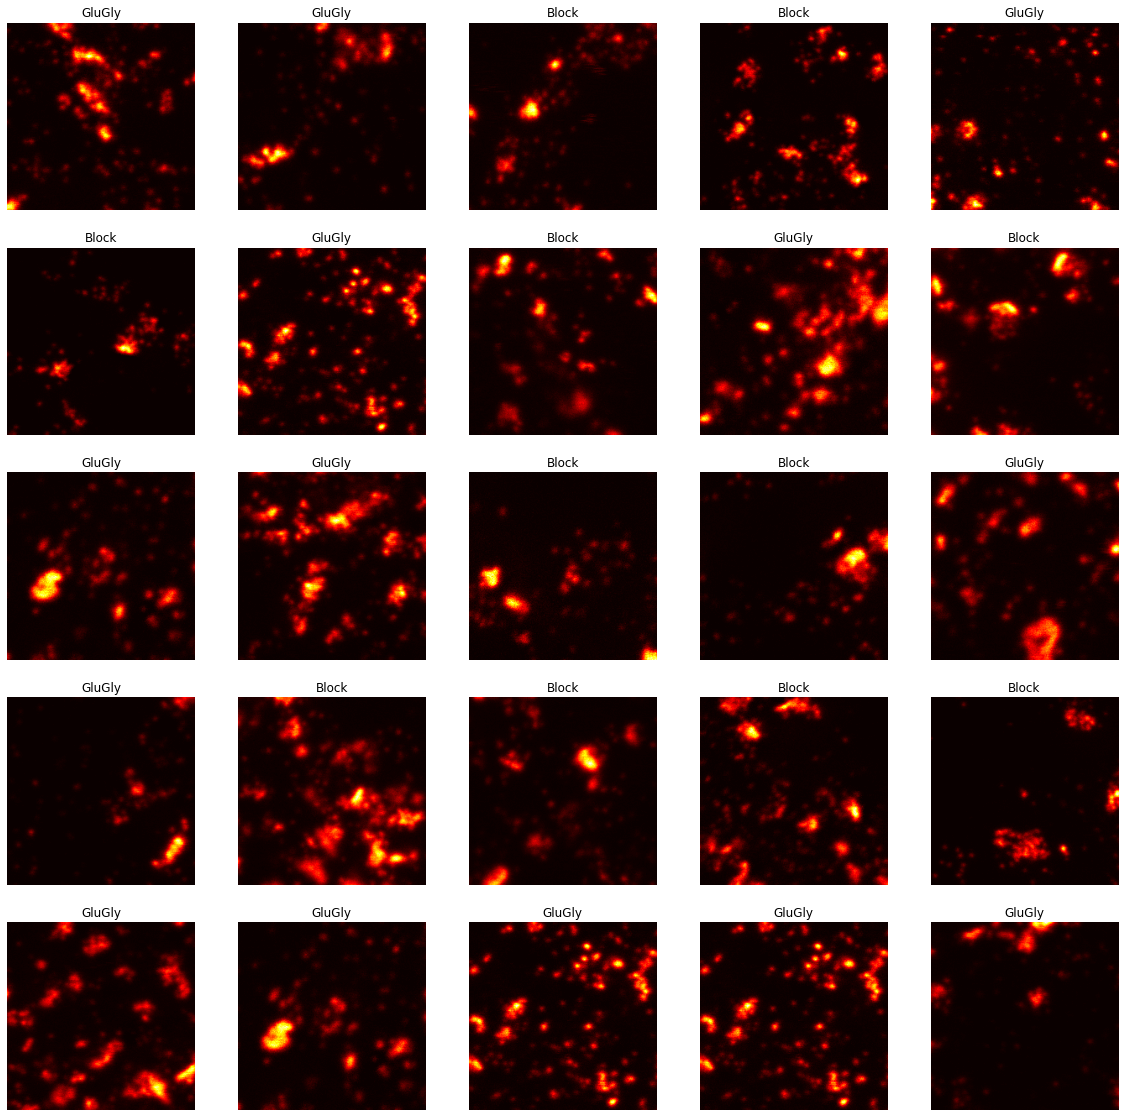

In [60]:
### Check why actin is getting split into two clusters 
print(np.unique(clusters1))
c1_indices = np.where(clusters1 == 1)[0]
c2_indices = np.where(clusters1 == 2)[0]
c1_indices = np.random.choice(c1_indices, size=25, replace=False)
c2_indices = np.random.choice(c2_indices, size=25, replace=False)

if N_CLASSES > 2:
    c3_indices = np.where(clusters1 == 3)[0]
    c4_indices = np.where(clusters1 == 4)[0]
    c3_indices = np.random.choice(c3_indices, size=25, replace=False)
    c4_indices = np.random.choice(c4_indices, size=25, replace=False)

fig, axs = plt.subplots(5, 5, figsize=(20,20))
for i, idx in enumerate(c3_indices):
    ax = axs.ravel()[i]
    d_idx = dataset_idx[idx]
    img = test_loader.dataset[d_idx][0]
    label = test_loader.dataset[d_idx][1]["label"]
    if label.dtype == np.float32:
        label = label.astype(np.int32)
    img = img.squeeze().cpu().numpy()
    ax.imshow(img, cmap="hot")
    ax.axis("off")
    ax.set_title(CLASSES[label])
plt.show()


### Manual feature analysis

In [67]:
from skimage import measure 
from wavelet import detect_spots

c1_indices = np.where(clusters1 == 1)[0]
c2_indices = np.where(clusters1 == 2)[0]
c3_indices = np.where(clusters1 == 3)[0]
c4_indices = np.where(clusters1 == 4)[0]

manual_features = {
    key: [] * len(np.unique(labels)) for key in np.unique(clusters1)
}

for i, indices in enumerate([c1_indices, c2_indices, c3_indices, c4_indices]):
    for idx in indices:
        d_idx = dataset_idx[idx]
        img = test_loader.dataset[d_idx][0]
        label = test_loader.dataset[d_idx][1]["label"]
        if label.dtype == np.float32:
            label = label.astype(np.int32)
        img = img.squeeze().cpu().numpy()
        mask = detect_spots(img)
        mask_label, num_proteins = measure.label(mask, return_num=True)
        props = measure.regionprops(mask_label, intensity_image=img)
        areas, perimeters, eccentricities, mean_intensities, number_of_proteins = [], [], [], [], []
        for prop in props:
            areas.append(prop.area)
            perimeters.append(prop.perimeter)
            eccentricities.append(prop.eccentricity)
            mean_intensities.append(prop.mean_intensity)
        manual_features[i + 1].append([np.mean(areas), np.mean(perimeters), np.mean(eccentricities), np.mean(mean_intensities), num_proteins])
        

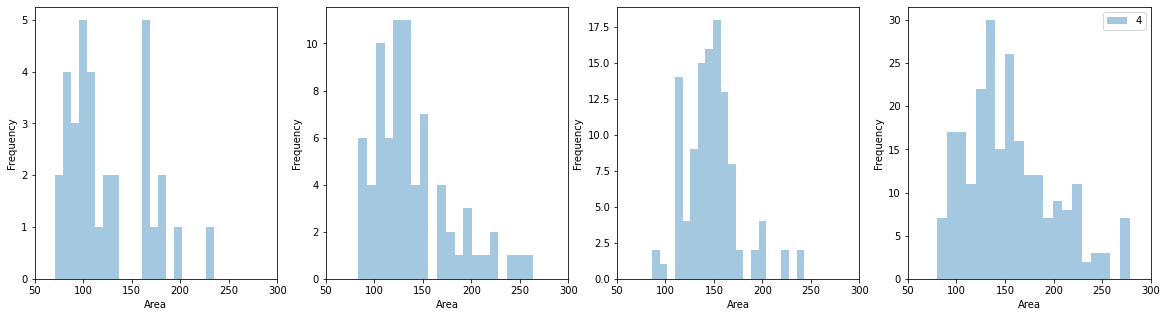

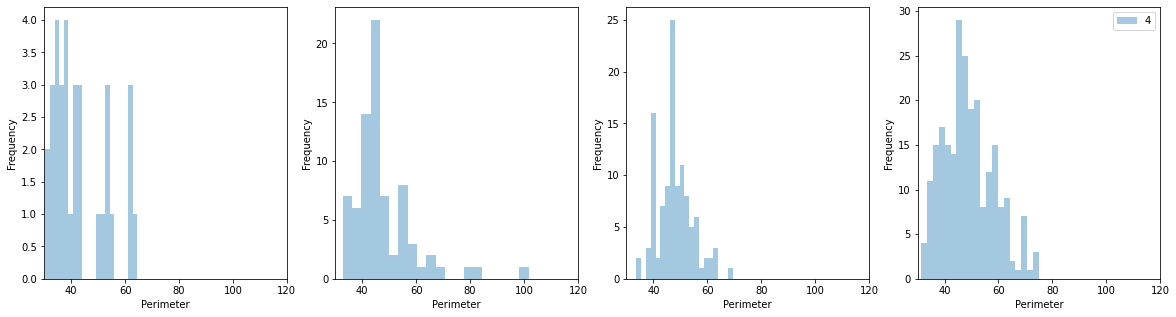

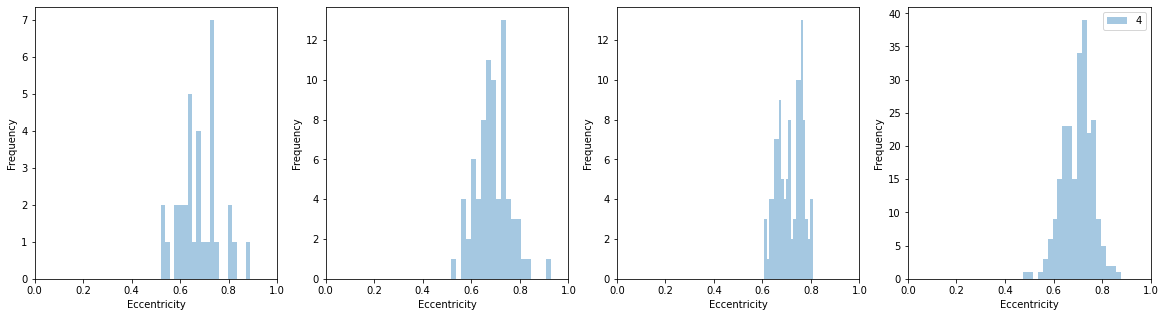

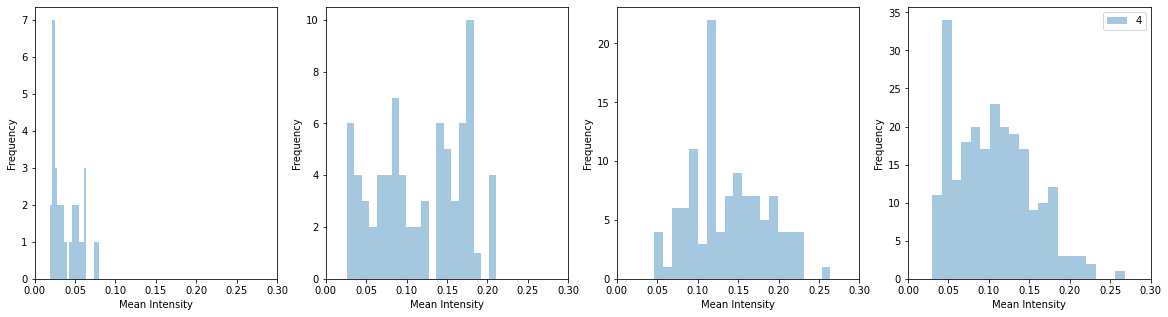

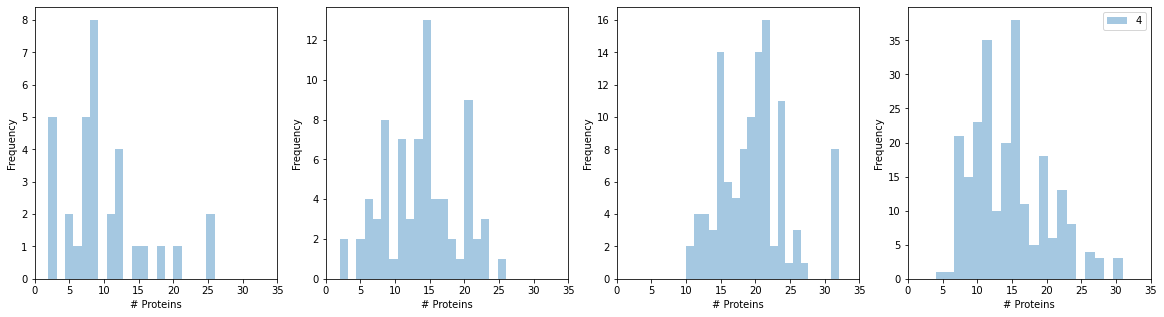

In [80]:

feature_names = ["Area", "Perimeter", "Eccentricity", "Mean Intensity", "# Proteins"]
xlims = [[50, 300], [30, 120], [0, 1], [0, 0.30], [0, 35]]
for i in range(np.array(manual_features[1]).shape[1]):
    fig, axs = plt.subplots(1, len(manual_features.keys()), figsize=(20, 5))
    for key in manual_features.keys():
        features = np.array(manual_features[key])
        data = features[:, i]
        axs[key - 1].hist(data, bins=20, alpha=0.4, label=key)
        axs[key - 1].set_xlabel(feature_names[i])
        axs[key - 1].set_ylabel("Frequency")
        axs[key - 1].set_xlim(xlims[i])
    plt.legend()
    plt.show()

In [86]:
import tarfile 
import io

with tarfile.open("/home-local/Frederic/Datasets/ALS/catalog/test_ALS.tar", "r") as handle:
    members = handle.getmembers()
    # for m in members:
    m = members[0]
    buffer = io.BytesIO()
    buffer.write(handle.extractfile(m).read())
    buffer.seek(0)
    data = np.load(buffer, allow_pickle=True)
    data = {key: values for key, values in data.items()}
    print(data.keys())
    img = data["img"]
    print(img.min(), img.max())
    print(img.shape)
    print(data["metadata"])

dict_keys(['img', 'segmentation', 'metadata'])
0.0 0.3201022847931101
(224, 224)
{'condition': 'shFUS', 'batch_id': '(25)', 'DIV': 'DIV5', 'DPI': '7DPI', 'protein': 'PSD95'}
